# Setup the Yolo Custom Dataset

The Image Processing workflow

```mermaid
flowchart LR

A(1. Collect Images) --> B(2. Annotate Images)
B --> C(3. Split Data)
C --> D(4. Train)
D --> E(5. Evaluate)
E --> F(6. Deploy)
F --> G(7. Quantize)

```

In [58]:
import os
import torch
from torch.utils.data import Dataset, Dataloader
from torchvision import transforms
from PIL import Image

class YoloDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_filenames = os.listdir(img_dir)

        # Filter out non-image files (e.g., .DS_Store)
        self.img_filenames = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]


    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        # Get image file path and load the image
        img_filename = self.img_filenames[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert("RGB")
        
        # Get corresponding label file path and load the labels
        label_filename = img_filename.replace(".jpeg", ".txt")  # assuming images are .jpg
        label_path = os.path.join(self.label_dir, label_filename)
        
        boxes = []
        labels = []
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                
                # YOLO format: normalize bbox (x_center, y_center, width, height) relative to image dimensions
                image_width, image_height = image.size
                x_center *= image_width
                y_center *= image_height
                width *= image_width
                height *= image_height
                
                # Convert YOLO format to (x_min, y_min, x_max, y_max) for PyTorch
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2
                
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.long)

        # Prepare target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        # Apply any image transformations
        if self.transform:
            image = self.transform(image)

        return image, target

## Define any image transforms (e.g., resizing, normalization)

In [31]:
# Define any image transforms (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((416, 416)),  # Example size; YOLO uses 416x416
    transforms.ToTensor()
])

def custom_collate_fn(batch):
    images = []
    targets = []

    for sample in batch:
        images.append(sample[0])  # Append image tensor
        targets.append(sample[1])  # Append target dictionary

    # Stack images (assuming all images are resized to the same size)
    images = torch.stack(images, dim=0)

    # Targets remain as a list of dictionaries with variable-sized tensors
    return images, targets

> The code below makes sure we're in the right folder

In [65]:
target_wd = "/Users/kev/Python/object_detection"
os.chdir(target_wd)
print(f"Current working directory is: {os.getcwd()}")
current_dir = os.getcwd()
print(f"Current dir: {current_dir}")

Current working directory is: /Users/kev/Python/object_detection
Current dir: /Users/kev/Python/object_detection


## Associate labels and Images 

In [66]:
img_dir = os.path.join(current_dir, "data/images")
label_dir = os.path.join(current_dir, "data/labels")

dataset = YoloDataset(img_dir=img_dir, label_dir=label_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

# Iterate through the dataset
for images, targets in dataloader:
    print(images.shape)  # e.g., torch.Size([4, 3, 416, 416])
    print(targets)

torch.Size([4, 3, 416, 416])
[{'boxes': tensor([[ 579.9987, 1725.0005, 1723.9990, 3074.9988],
        [   5.0017,  774.9988,  936.0005, 1887.0002]]), 'labels': tensor([15, 15])}, {'boxes': tensor([[ 217.9986, 1625.0009, 1742.9988, 2500.0012]]), 'labels': tensor([17])}, {'boxes': tensor([[2021.9996, 1377.0011, 2902.9998, 2265.0017]]), 'labels': tensor([16])}, {'boxes': tensor([[2009.0024, 1539.9993, 2859.0005, 2246.0005]]), 'labels': tensor([16])}]
torch.Size([4, 3, 416, 416])
[{'boxes': tensor([[ 436.0018, 1386.9999, 2043.0007, 2369.0017]]), 'labels': tensor([17])}, {'boxes': tensor([[1478.0001,  458.0014, 3297.0007, 2690.0007]]), 'labels': tensor([17])}, {'boxes': tensor([[ 724.0001,  780.9984, 1968.0011, 2030.9990],
        [ 749.0010, 2106.0022, 1643.0012, 3125.0017]]), 'labels': tensor([15, 15])}, {'boxes': tensor([[1364.9973,  807.9992, 2471.9990, 2065.0005]]), 'labels': tensor([15])}]
torch.Size([4, 3, 416, 416])
[{'boxes': tensor([[  18.0004, 1105.9998,  923.9998, 2074.9983],
  

## Splitting datasets

In [ ]:
import sys
import os

# Example usage:
image_dir = img_dir
label_dir = label_dir
output_dir = 'split'
target_wd = "/Users/kev/Python/object_detection/"

# Add the current directory (or the directory where split_helper.py is located) to the system path
sys.path.append(os.getcwd())

os.chdir(target_wd)

print(os.getcwd())


from split_helper import split_dataset

# Split with 80% training and 20% validation
split_dataset(image_dir, label_dir, output_dir, train_ratio=0.8)


## Prepare test and train datasets 

In [72]:
training_data = YoloDataset(img_dir='split/images/train', label_dir='split/labels/train', transform=transform)
test_data = YoloDataset(img_dir='split/images/val', label_dir='split/labels/val', transform=transform)

# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=custom_collate_fn)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")  # X is a batch of images
    
    for i, target in enumerate(y):
        print(f"Image {i}:")
        print(f"  Number of boxes: {target['boxes'].shape[0]}")
        print(f"  Shape of boxes: {target['boxes'].shape}")
        print(f"  Shape of labels: {target['labels'].shape}")
    
    break  # Only checking the first batch


Shape of X [N, C, H, W]: torch.Size([33, 3, 416, 416])
Image 0:
  Number of boxes: 2
  Shape of boxes: torch.Size([2, 4])
  Shape of labels: torch.Size([2])
Image 1:
  Number of boxes: 2
  Shape of boxes: torch.Size([2, 4])
  Shape of labels: torch.Size([2])
Image 2:
  Number of boxes: 1
  Shape of boxes: torch.Size([1, 4])
  Shape of labels: torch.Size([1])
Image 3:
  Number of boxes: 2
  Shape of boxes: torch.Size([2, 4])
  Shape of labels: torch.Size([2])
Image 4:
  Number of boxes: 1
  Shape of boxes: torch.Size([1, 4])
  Shape of labels: torch.Size([1])
Image 5:
  Number of boxes: 1
  Shape of boxes: torch.Size([1, 4])
  Shape of labels: torch.Size([1])
Image 6:
  Number of boxes: 1
  Shape of boxes: torch.Size([1, 4])
  Shape of labels: torch.Size([1])
Image 7:
  Number of boxes: 2
  Shape of boxes: torch.Size([2, 4])
  Shape of labels: torch.Size([2])
Image 8:
  Number of boxes: 1
  Shape of boxes: torch.Size([1, 4])
  Shape of labels: torch.Size([1])
Image 9:
  Number of boxes:

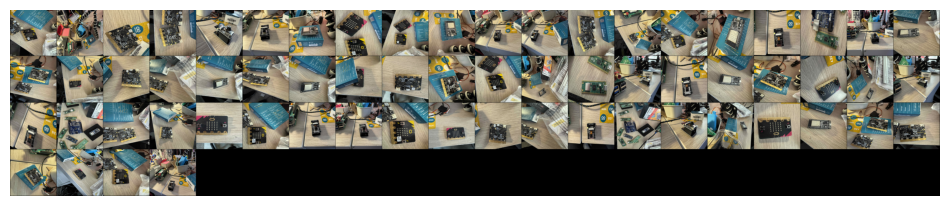

In [81]:
import torchvision.utils as vutils
import numpy as np
from PIL import Image
# Visualize a grid of images (without bounding boxes)
def visualize_image_grid(images, nrow=20):
    grid_img = vutils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(grid_img.cpu().numpy(), (1, 2, 0)))  # Convert to HWC format for plt
    plt.axis('off')
    plt.show()

# Example usage:
for images, targets in train_dataloader:
    visualize_image_grid(images)
    break  # Only visualize the first batch


Skipping invalid box: [ 668.00006 1600.0004  1818.0001  2811.9995 ]
Skipping invalid box: [3937.0017 2527.999  4692.0024 3163.9976]
Skipping invalid box: [ 228.00305 3754.9988   792.00024 4190.9985 ]
Skipping invalid box: [1472.0005   971.00037 2390.0022  2026.9993 ]
Skipping invalid box: [1015.0016 1101.9985 2590.0015 1820.9999]
Skipping invalid box: [ 518.0006 2506.001  2136.001  4032.    ]


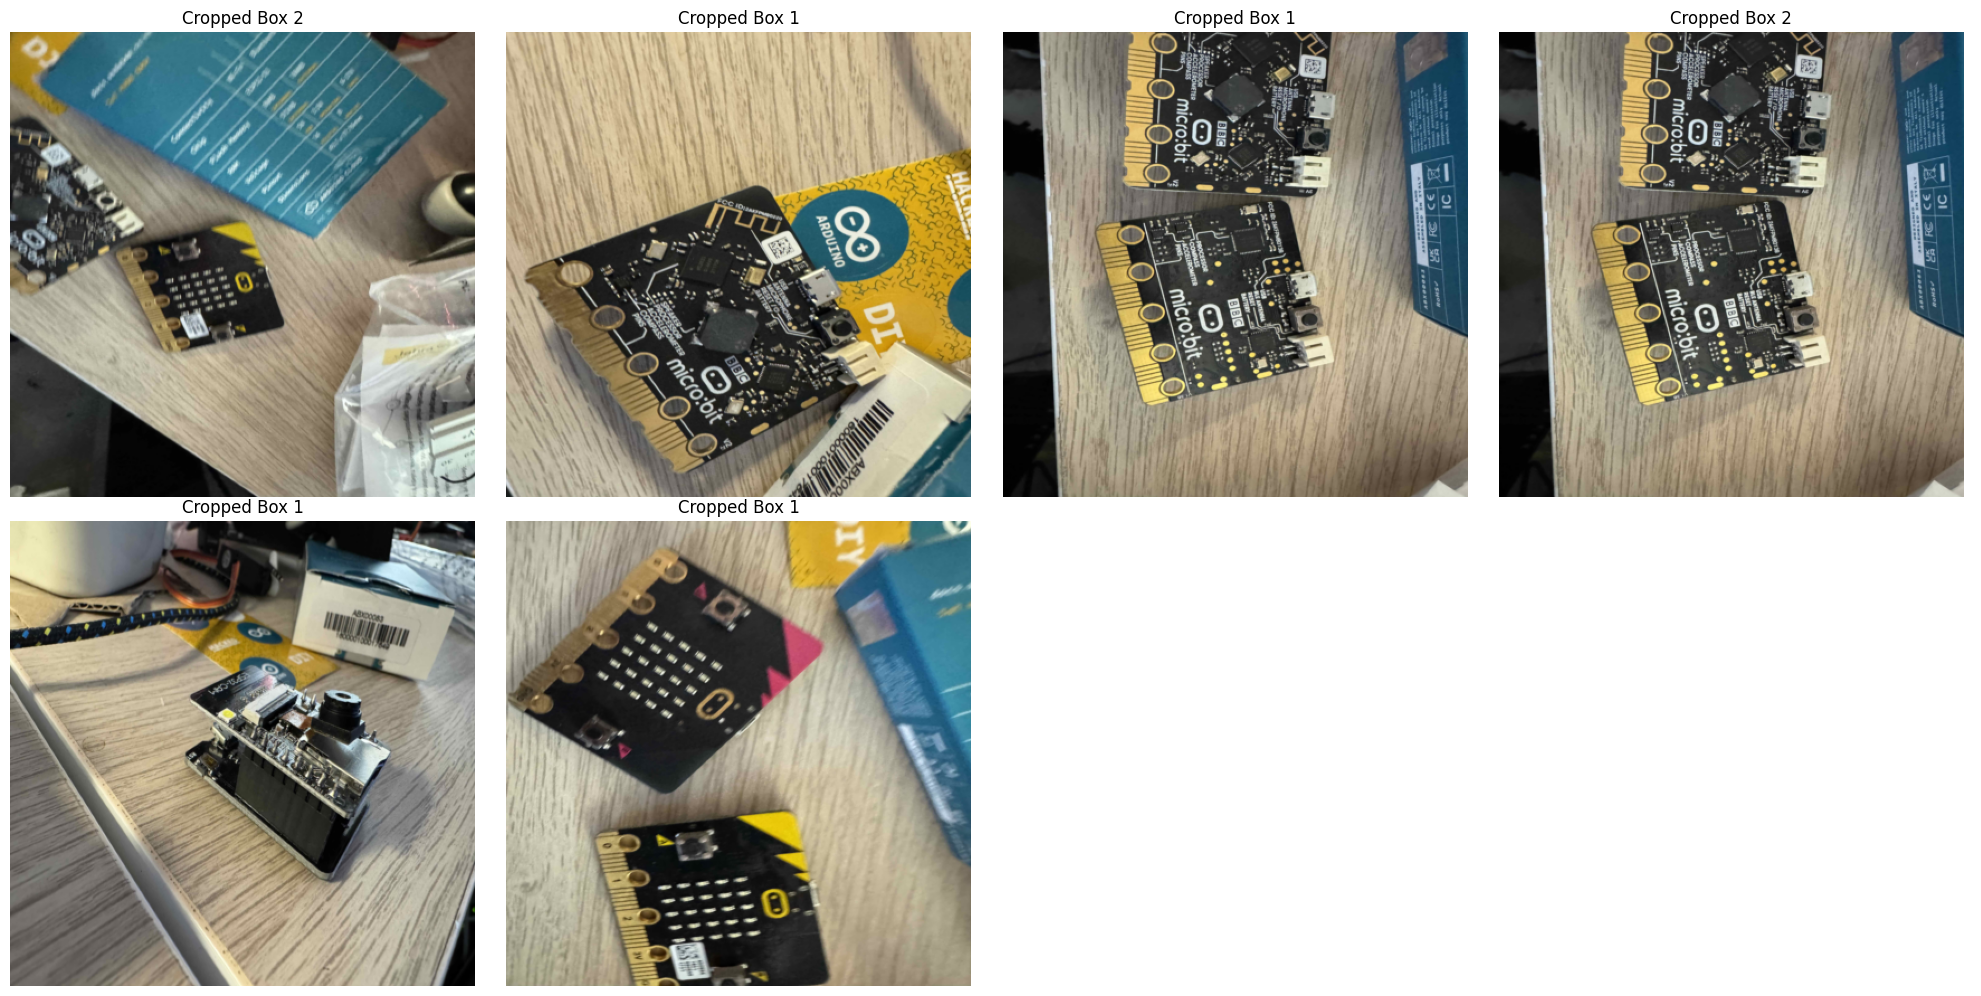

In [84]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from PIL import Image
import torch

# Convert tensor to a PIL image
to_pil = ToPILImage()

# Function to visualize cropped images from bounding boxes using matplotlib subplots
def visualize_cropped_boxes(dataloader, num_images=8):
    # Get a batch of images and targets
    images, targets = next(iter(dataloader))

    # Create subplots: adjust the size based on the number of cropped regions
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust rows and columns based on your preference

    # Flatten the axis for easier iteration
    axs = axs.flatten()

    image_counter = 0  # Keep track of how many cropped regions we display

    # Visualize cropped images from bounding boxes (up to num_images crops)
    for i in range(min(len(images), num_images)):
        # Convert the image tensor to PIL for easier plotting
        img = to_pil(images[i].cpu())

        # Get image width and height
        img_width, img_height = img.size

        # Get bounding boxes and labels from the target
        boxes = targets[i]['boxes'].cpu().numpy()

        # For each bounding box, convert to pixel coordinates, crop the image, and display it
        for j, box in enumerate(boxes):
            if image_counter >= num_images:
                break

            # Assuming boxes are normalized (x_center, y_center, width, height), convert to pixel values
            x_center, y_center, box_width, box_height = box

            # Convert from normalized coordinates to absolute pixel values
            x_center *= img_width
            y_center *= img_height
            box_width *= img_width
            box_height *= img_height

            # Calculate pixel coordinates for cropping
            x_min = max(0, x_center - (box_width / 2))
            y_min = max(0, y_center - (box_height / 2))
            x_max = min(img_width, x_center + (box_width / 2))
            y_max = min(img_height, y_center + (box_height / 2))

            # Ensure valid box dimensions (skip invalid boxes)
            if x_min >= x_max or y_min >= y_max:
                print(f"Skipping invalid box: {box}")
                continue

            # Crop the image to the bounding box area
            cropped_img = img.crop((x_min, y_min, x_max, y_max))

            # Display the cropped image
            axs[image_counter].imshow(cropped_img)
            axs[image_counter].axis('off')  # Turn off the axis for clean display
            axs[image_counter].set_title(f"Cropped Box {j+1}")

            image_counter += 1

        if image_counter >= num_images:
            break

    # Turn off unused subplots
    for j in range(image_counter, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_cropped_boxes(train_dataloader)


In [3]:
import torch
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

from torch import nn

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        # Adjust this layer based on the actual flattened size
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(519168, 512),  # Adjust input size here
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=519168, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        # YOLO models typically expect a different loss function that handles
        # bounding boxes, objectness, and class predictions.

        # Move targets (list of dictionaries) to device
        targets = [{k: v.to(device) for k, v in t.items()} for t in y]

        # Compute predictions and losses directly from the YOLO model
        # This will internally calculate the correct loss (classification, bounding box regression, etc.)
        results = model(X, targets)
        
        # YOLO training usually returns a loss dictionary with keys like 'loss', 'box', 'cls', 'obj'
        loss = results['loss']  # You can access individual losses like results['box'] for bbox loss, etc.

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss_value = loss.item()
            current = (batch + 1) * len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            
            # Move targets (list of dictionaries) to device
            targets = [{k: v.to(device) for k, v in t.items()} for t in y]

            pred = model(X)

            # Compute test loss
            test_loss += loss_fn(pred, targets).item()

            # Here, you can calculate accuracy if you're dealing with class predictions
            # Correct computation will depend on your model architecture (classification accuracy is not enough for object detection)
            # Example:
            # correct += some_accuracy_metric(pred, targets)

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

# Train the Model

In [11]:
# original quantize
from ultralytics import YOLO
import os

# This is because some features have not yet been released for MPS (on Apple Silicon)
torch.backends.mps.enable_fallback = True

# Set the environment variable
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Check if MPS is available, otherwise fallback to CPU
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# Load a pretrained YOLOv5 model (or YOLOv8)
model = YOLO('yolov5su.pt')  # You can use 'yolov5m.pt', 'yolov5l.pt', etc., for different model sizes

# Move the model to the MPS device
model.to(device)

# Set this to 50 or more for accurate detection (50 takes around an hour on a MacBook Pro M1
epochs = 1 

# Train the model on your dataset
model.train(data='/Users/kev/Python/object_detection/dataset.yml', epochs=epochs, imgsz=640)

# Apply Quantization-Aware Training
model.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
torch.quantization.prepare_qat(model, inplace=True)

# # Fine-tune or re-train the model (with a few epochs)
# for epoch in range(10):  # Adjust the number of epochs
#     train(train_dataloader, model, loss_fn, optimizer)
#     test(test_dataloader, model, loss_fn)

if device == 'cpu':
    # Set the quantization engine and apply quantization
    torch.backends.quantized.engine = 'qnnpack'  # For CPUs
    torch.quantization.prepare_qat(model, inplace=True)
    torch.quantization.convert(model, inplace=True)
else:
    print("Quantization is not supported on this device. Skipping quantization.")



New https://pypi.org/project/ultralytics/8.3.18 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=/Users/kev/Python/object_detection/dataset.yml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps:0, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

train: Scanning /Users/kev/Python/object_detection/split/labels/train.cache... 8
val: Scanning /Users/kev/Python/object_detection/split/labels/val.cache... 33 im

Plotting labels to /Users/kev/Python/object_detection/runs/detect/train23/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000357, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/kev/Python/object_detection/runs/detect/train23
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.32G      1.059       4.82      1.315          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         33         54     0.0175      0.289     0.0437     0.0386

1 epochs completed in 0.010 hours.
Optimizer stripped from /Users/kev/Python/object_detection/runs/detect/train23/weights/last.pt, 18.5MB
Optimizer stripped from /Users/kev/Python/object_detection/runs/detect/train23/weights/best.pt, 18.5MB

Validating /Users/kev/Python/object_detection/runs/detect/train23/weights/best.pt...
Ultralytics 8.3.17 🚀 Python-3.10.6 torch-2.4.1 MPS (Apple M1)
YOLOv5s summary (fused): 193 layers, 9,120,824 parameters, 0 gradients, 23.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         33         54     0.0175      0.289     0.0435     0.0384
             Micro:Bit         22         35       0.15        0.6      0.267      0.231
              ESP32Cam          4          4    0.00601          1      0.114      0.106
               ESP8266          5          5          0          0          0          0
        Arduino Uno R3          1          1    0.00172          1     0.0106    0.00953
   Raspberry Pi Pico W          1          2          0          0          0          0
   Raspberry Pi Pico 2          1          1          0          0          0          0
     Raspberry Pi Pico          1          4          0          0          0          0
    Arduino Nano ESP32          1          1          0          0          0          0
    Arduino Nano Every          1          1          0          0          0          0
Speed: 0.7ms preprocess, 91.0ms inference, 0.0ms loss, 18.2ms postprocess per image
Results saved to /Users/ke

In [6]:
# train with quantize

from torch.quantization import quantize_qat

# Ensure model is in training mode
model.train()


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=519168, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [15]:
# Move the quantized model to CPU before running quantized operations
model.to('cpu')

# Perform inference (on a single image or batch of images)
results = model('/Users/kev/Python/object_detection/test.jpg')

# Evaluate the model on a test dataset
metrics = model.val(data='/Users/kev/Python/object_detection/dataset.yml')


image 1/1 /Users/kev/Python/object_detection/test.jpg: 640x480 (no detections), 195.5ms
Speed: 6.2ms preprocess, 195.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


val: Scanning /Users/kev/Python/object_detection/split/labels/val.cache... 33 im
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         33         54     0.0204      0.406     0.0486     0.0435
             Micro:Bit         22         35      0.163      0.657      0.225      0.197
              ESP32Cam          4          4    0.00581          1      0.178      0.169
               ESP8266          5          5          0          0          0          0
        Arduino Uno R3          1          1    0.00173          1    0.00544    0.00489
   Raspberry Pi Pico W          1          2          0          0          0          0
   Raspberry Pi Pico 2          1          1     0.0127          1     0.0293     0.0205
     Raspberry Pi Pico          1          4          0          0          0          0
    Arduino Nano ESP32          1          1          0          0          0          0
    Arduino Nano Every          1          1          0          0          0          0
Speed: 1.7ms preprocess, 354.0ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to /Users/ke

# Export as ONNX format model
(Open Neural Network Exchange format)

In [18]:
from ultralytics import YOLO

# Load your trained YOLO model (the best.pt from your previous training)
model = YOLO('/Users/kev/Python/object_detection/runs/detect/train23/weights/best.pt')

# Export the model to ONNX format with a lower opset version (e.g., 16)
model.export(format='onnx', opset=16, imgsz=640)  # Specify opset=16 as per your tool's requirements




Ultralytics 8.3.17 🚀 Python-3.10.6 torch-2.4.1 CPU (Apple M1)
YOLOv5s summary (fused): 193 layers, 9,120,824 parameters, 0 gradients, 23.9 GFLOPs

PyTorch: starting from '/Users/kev/Python/object_detection/runs/detect/train23/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 28, 8400) (17.7 MB)

ONNX: starting export with onnx 1.15.0 opset 16...
ONNX: slimming with onnxslim 0.1.35...
ONNX: export success ✅ 0.8s, saved as '/Users/kev/Python/object_detection/runs/detect/train23/weights/best.onnx' (35.0 MB)

Export complete (1.3s)
Results saved to /Users/kev/Python/object_detection/runs/detect/train23/weights
Predict:         yolo predict task=detect model=/Users/kev/Python/object_detection/runs/detect/train23/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/Users/kev/Python/object_detection/runs/detect/train23/weights/best.onnx imgsz=640 data=/Users/kev/Python/object_detection/dataset.yml  
Visualize:       https://netron.app


'/Users/kev/Python/object_detection/runs/detect/train23/weights/best.onnx'

## Quantise the model for use with Raspberry Pi

The Raspberry Pi AI Camera is designed to handle models optimized for efficiency, using smaller numerical representations, such as 8-bit integers, instead of the standard 32-bit or 64-bit floating-point values typically used during training. 

To convert the model for more efficient use on devices with limited computational power (such as the Raspberry Pi), we need to quantize it. Quantization reduces the model size and speeds up inference by converting the weights and activations from floating-point precision (e.g., 32-bit or 64-bit) to lower precision (e.g., 8-bit integers), while maintaining an acceptable level of accuracy.

### Install the prerequisites

In [265]:
!pip install -q pycocotools
!pip install -q torch
!pip install onnx
!pip install -q pycocotools
!pip install 'huggingface-hub>=0.21.0'
!pip install sony-custom-layers

Python(83519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83522) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(83544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(83563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


## Begin Quantising the model for use on Raspberry Pi AI Camera

## Perform post training quantization

In [21]:
# Load the saved model checkpoint
model_path = '/Users/kev/Python/object_detection/runs/detect/train23/weights/best.pt'
checkpoint = torch.load(model_path, map_location='cpu')

# Extract the model weights from the checkpoint
state_dict = checkpoint['model'].state_dict()

# Load the weights into the model (after adjusting the head)
model.model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore mismatched keys

<All keys matched successfully>

In [22]:
from torch import nn

def replace_silu_with_relu(model):
    for name, module in model.named_children():
        if isinstance(module, nn.SiLU):
            setattr(model, name, nn.ReLU(inplace=True))
        else:
            replace_silu_with_relu(module)  # Recursively replace for nested layers

replace_silu_with_relu(model.model)  # Assuming your YOLO model is inside `model.model`


# Quantize the model using pytorch quantization

In [23]:
# Quantize the model using pytorch quantization

import torch.quantization as quant

# Load the checkpoint
checkpoint = torch.load(model_path)

# If the checkpoint contains the model in 'model_state_dict', extract it
model_fp32 = checkpoint['model']  # Or 'state_dict' or similar depending on how the model was saved

# Set the model to evaluation mode
model_fp32.eval()

# Apply dynamic quantization
model_int8 = quant.quantize_dynamic(
    model_fp32, {torch.nn.Linear}, dtype=torch.qint8
)

# Save the quantized model
torch.save(model_int8, "best_quantized.pt")


In [365]:
# Export to ONNX format

In [24]:
# Export to ONNX format
import torch

# Load the quantized model
quantized_model = torch.load("best_quantized.pt")

# Set the model to evaluation mode
quantized_model.eval()

# Convert all model parameters to float (FP32)
quantized_model = quantized_model.float()

# Define a dummy input with the correct shape (adjust this to match your model's input shape)
dummy_input = torch.randn(1, 3, 640, 640).float()  # Ensure dummy input is also FP32

# Export the model to ONNX format
torch.onnx.export(
    quantized_model,                  # Model to be exported
    dummy_input,                      # Dummy input for the model
    "best_quantized.onnx",            # Output file path for the ONNX model
    export_params=True,               # Store trained parameters (weights) in the ONNX model
    opset_version=17,                 # ONNX opset version (change if necessary)
    do_constant_folding=True,         # Enable constant folding optimization
    input_names=['input'],            # Input tensor name
    output_names=['output'],          # Output tensor name
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Dynamic axis for batch size
)

print("Model successfully exported to ONNX format.")


Model successfully exported to ONNX format.


In [25]:
# Model preparation
model_fp32.eval()  # Ensure model is in eval mode
model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')  # Set quantization config

import torch
import torch.nn as nn

def fuse_model_layers(model):
    """
    Procedurally fuse Conv, BatchNorm, and Activation layers in a given model.
    """
    # Go through each layer of the model
    for module_name, module in model.named_children():
        # Check if the module has children (e.g., Sequential, custom blocks)
        if len(list(module.children())) > 0:
            # Recursively apply fusion to child modules
            fuse_model_layers(module)
        
        # Check for patterns: Conv -> BatchNorm -> Activation (e.g., ReLU, SiLU)
        if isinstance(module, nn.Sequential):
            layer_list = []
            conv_idx, bn_idx, act_idx = None, None, None

            # Iterate through the layers in the Sequential block
            for idx, (name, layer) in enumerate(module.named_children()):
                # Track indices of Conv, BatchNorm, and Activation layers
                if isinstance(layer, nn.Conv2d):
                    conv_idx = idx
                elif isinstance(layer, nn.BatchNorm2d):
                    bn_idx = idx
                elif isinstance(layer, (nn.ReLU, nn.SiLU)):
                    act_idx = idx

                # If we have a Conv -> BatchNorm -> Activation sequence, fuse them
                if conv_idx is not None and bn_idx is not None and act_idx is not None:
                    # Fuse the layers
                    fused = torch.quantization.fuse_modules(module, [str(conv_idx), str(bn_idx), str(act_idx)], inplace=True)
                    layer_list.append(fused)
                    # Reset indices
                    conv_idx, bn_idx, act_idx = None, None, None

    return model

# Apply procedural fusion
fused_model = fuse_model_layers(model_fp32)

# Now you can proceed with quantization

# Prepare for quantization
model_prepared = torch.quantization.prepare(fused_model)


---


In [ ]:
# IGNORE
import torch
import torch.quantization

# Set the quantization backend to 'qnnpack' since 'fbgemm' is not supported
torch.backends.quantized.engine = 'qnnpack'

# Proceed with your quantization code:
model_fp32.eval()  # Ensure the model is in eval mode
model_fp32.qconfig = torch.quantization.get_default_qconfig('qnnpack')  # Use 'qnnpack' for ARM

# Prepare the model for quantization
model_fp32_prepared = torch.quantization.prepare(model_fp32)

# Calibrate the model using your dataloader
calibrate_model(model_fp32_prepared, train_dataloader)

# Convert the model to INT8
model_int8 = torch.quantization.convert(model_fp32_prepared)

print("Model has been quantized to 8-bit integer format using qnnpack.")


In [ ]:
# THIS FAILS DO NOT USE
# Dummy input
dummy_input = torch.randn(1, 3, 640, 640)

# Export quantized model to ONNX
torch.onnx.export(
    model_int8,  # Your quantized model
    dummy_input,
    "quantized_model.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
print("Model exported to ONNX format")


In [27]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Specify the path to your exported ONNX model
onnx_model_path = "best_quantized.onnx"
quantized_model_path = "model_int8.onnx"

# Perform dynamic quantization
quantize_dynamic(onnx_model_path, quantized_model_path, weight_type=QuantType.QInt8)

print(f"Quantized model saved at {quantized_model_path}")


Quantized model saved at model_int8.onnx


In [28]:
# Save the model
torch.save(model_int8.state_dict(), 'quantized_model.pt')

In [29]:
# Quantize the model using PyTorch
import torch.onnx

# Convert the model's parameters and buffers back to float32
model = model.half()  # Assuming the model was previously converted to half-precision
model = model.float()  # Convert it back to float32

# Convert the model to float32
model_int8 = model_int8.float()

# Create a dummy input tensor in float32
dummy_input = torch.randn(1, 3, 640, 640, dtype=torch.float32)

# Export the PyTorch model to ONNX
torch.onnx.export(
    model_int8,  # The PyTorch model (ensure it is already quantized)
    dummy_input,  # Dummy input tensor in float32
    "quantized_model.onnx",  # Output file name
    export_params=True,  # Store the trained parameters in the model file
    opset_version=17,  # ONNX opset version
    do_constant_folding=True,  # Optimize constant expressions
    input_names=['input'],  # Input tensor names
    output_names=['output'],  # Output tensor names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Enable dynamic batching
)

print("Quantized model exported successfully.")

Quantized model exported successfully.
